#                          Logistic Regression for MNIST

In [323]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn.model_selection import train_test_split


### SOFTMAX

#### Softmax = exp(a)/sum(exp(a)

 _To bound the softmax values within float:_  
 
 #### Softmax = exp(a-max(a))/sum(exp(a))



In [324]:

def softmax(z):
   
    z-=np.max(z)         # normalize to avoid exp overflow when value exceeds float64 upper bound
    exps    = np.exp(z)
    softmax = exps / np.sum(exps,axis = 1,keepdims =True)           #Keeps original dimensions of the input vector,so keepdims = True
    return softmax              #[N x K]



### Cross entropy error

_Cross Entropy error is the negative log likelyhood_

_Get the label (one-hot encoded vectors) : index [ max of label ] corresponds to the class_


In [325]:
def cross_entropy_error(input,no_of_images,label ):
    class_indices = None
    logprobs = []
    s = softmax(input)
    class_indices = label.argmax(axis=1)
    
    for index in range(no_of_images):
        logprobs.append(-np.log(s[index,class_indices[index]]))

    CE_error = np.sum(logprobs)/no_of_images
    return CE_error



### Calculate Gradients

_To Calculate dervivative of log likelihood_

_input to function is "pred= wTx + b"
_grad = softmax(pred)-1
_Remember label is onehot encoded vector with 1 @ class index_




In [410]:
def calculate_grad(input,no_of_images,label):

    grad = softmax(input)
    class_indices = None

    class_indices = label.argmax(axis=1)
    #Use argmax of output label matrix
    for index in range(no_of_images):
        grad[index,class_indices[index]] -= 1
  
    #Normalizing the gradients
    grad= grad /no_of_images
    return grad




### Calculate Accuracy

_Get the positions of max value in prediction and compare with y_class of the corresponding label to get the accuracy 

In [358]:
def accuracy(input,output,W,W0):
    predicted_class = None
    pred = softmax(np.dot(input[:],W)+W0)
    predicted_class = np.argmax(pred,axis = 1)
    #output_label is in form of one-hot encoded vectors of labels 
    #So taking argmax(axis=1) in order to convert into [N x 1] matrix
    y_class = np.argmax(output[:],axis = 1)
    result =  np.mean(predicted_class == y_class)
    return result

## Stochastic Gradient Descent

__Batch wise gradient Descent approach for faster convergence__

In [409]:
def sgd(X_train,Y_train,batch_size,lr,itr,display_error=0):

    X ,Xval,Y,Yval = train_test_split(X_train, Y_train, test_size=1/6)

     
    #initialize random weights and bias
    print("\n batch size :{}".format(batch_size))       
    batches = []
    for b in range(0,X.shape[0],batch_size):
        batches.append((X[b:b + batch_size], Y[b:b + batch_size]))
    
    train_loss_list =[]
    val_loss_list = []

    train_likelihood = []
    val_likelihood = []
    
    train_accuracy = []
    val_accuracy = []

    X_val=Xval[:]
    Y_val=Yval[:]
    #Output in the form of One hot encoding vector form
    W = 0.01 *np.random.randn(X.shape[1],Y.shape[1])
    
    b = np.zeros(shape = (1,W.shape[1]))
    itr_counters = 0;

    for i in range(itr):
        itr_loss     = []          #Error of each iteration saved
        t_accuracy = []
        v_accuracy = []
        itr_counters = i
        batch_no=0
        
        for (Xbatch,Ybatch) in batches:
            batch_no+=1
            
            input = np.dot(Xbatch,W) + b
            batch_images_count = Xbatch.shape[0] 

            #calculate cross Entropy loss
            loss = cross_entropy_error(input,batch_images_count,Ybatch)
            itr_loss.append(loss)
            #calculate gradient 
            grad = calculate_grad(input,batch_images_count,Ybatch)

            dW = np.dot(Xbatch.T,grad)
            db = np.sum(grad,axis = 0,keepdims = True)

            #Perform parameter update
            W += -lr *dW
            b += -lr *db
            t_accuracy.append(accuracy(Xbatch,Ybatch,W,b))
            if display_error==1:
                print("\n Current iteration: {} Batch Number: {}".format(itr_counters,batch_no))
                print("\n Cross Entropy Error :{}".format(loss))
        
            #
        
        X ,Xval,Y,Yval = train_test_split(X_train, Y_train, test_size=1/6)
        v_accuracy=accuracy(X_val,Y_val,W,b)    
        val_accuracy.append(v_accuracy)
        train_accuracy.append(np.average(t_accuracy))
        
        
        input = np.dot(Xval,W) + b
        train_loss_list.append(np.average(itr_loss))
        v_loss = cross_entropy_error(input,Xval.shape[0],Yval)
        val_loss_list.append(v_loss)        
        
        print("\n Current iteration: {} train_Accuracy: {} validation_Acc: {} train loss: {} val loss: {}".format(itr_counters,np.average(t_accuracy),v_accuracy,loss,v_loss))

        train_likelihood.append(np.exp(-np.average(itr_loss)))
        val_likelihood.append(np.exp(-np.average(val_loss_list)))
        
        
    

    print("\n The Final value of W:{}".format(W))
    return W,b,train_loss_list,val_loss_list,train_likelihood,val_likelihood,train_accuracy,val_accuracy




## Multiclass Logistic Regression for MNIST Digit recognition Dataset

In [368]:

def mnist_logistic_reg(batch_size,lr,itr,display_error=0):
    
    dimension = 784
    nb_classes = 10
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.reshape(60000, dimension)
    X_test = X_test.reshape(10000, dimension)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255

    print("\n X_train :{}".format(X_train.shape))
    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    print("\n Y_train :{}".format(Y_train.shape))

    train_accuracy = []
    test_accuracy  = []
    
    
    weights,bias,train_loss,val_loss,t_likelihood,val_likelihood,train_acc,val_acc=sgd(X_train,Y_train,batch_size,lr,itr)

    acc = accuracy(X_test,Y_test,weights,bias)
    print("\n Final  Accuracy :%.4f {}".format(acc))

    
    return train_loss,val_loss,t_likelihood,val_likelihood,train_acc,val_acc


## Plotting Accuracy and Likelihood

In [369]:
def plot_loss_accuracy(itr,train_likelihood,val_likelihood,train_accuracy,val_accuracy):
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    plt.xlabel("itr")
    plt.ylabel("Likelihood")
    #plt.title("Train and Validation accuracy and Loglikelihood")


    r"""
    Plot the Likelihood vs itr
    """
    
    ax1.scatter(range(itr),train_likelihood,marker="^")
    ax1.title.set_text("Train Likelihood ")
    
    ax2.scatter(range(itr),val_likelihood,marker="^")
    ax2.title.set_text("Validation Likelihood ")
    
    plt.show()
    
    r"""
    Plot the classification accuracy vs itr
    """
    f, (ax3, ax4) = plt.subplots(1, 2, sharey=True)
    plt.xlabel("itr")
    plt.ylabel("Accuracy")

    ax3.scatter(range(itr),train_accuracy,marker="^")
    ax3.title.set_text("Train Accuracy ")
    
    ax4.scatter(range(itr),val_accuracy,marker="^")
    ax4.title.set_text("Validation Accuracy ")
    #ax4.xlabel("Epochs.")
    #ax4.ylabel("Classification Accuracy.")
    plt.show()

## Question

_Plot the Log likelihood and classification
accuracy on train and validation sets as a function of epochs. Report the test accuracy using
the weights learnt after the last epoch.
Comment on the influence of learning rate and batch size by performing the above experiments
using:_

_(a) Four different choices of learning rate 0.001, 0.01, 0.05, 0.1_

_(b) Four different choices of batch size 1, 32, 128, 1024._

## 1. Batch =1024 ; Learning Rate =0.001 ; 

In [374]:
batch_size=1024
lr=0.001
itr=15
t_loss,v_loss,train_likelihood,val_likelihood,train_accuracy,val_accuracy=mnist_logistic_reg(batch_size,lr,itr,display_error=0)


 X_train :(60000, 784)

 Y_train :(60000, 10)

 batch size :1024

 Current iteration: 0 train_Accuracy: 0.1995338672025414 validation_Acc: 0.2744 train loss: 2.2567743062472063 val loss: 2.254650261612537

 Current iteration: 1 train_Accuracy: 0.3621196783548325 validation_Acc: 0.4263 train loss: 2.2069679863745226 val loss: 2.205022858318549

 Current iteration: 2 train_Accuracy: 0.48626720735463996 validation_Acc: 0.536 train loss: 2.1591368823661514 val loss: 2.157265678598361

 Current iteration: 3 train_Accuracy: 0.5683307963515595 validation_Acc: 0.6058 train loss: 2.1130979516210595 val loss: 2.1107653798438126

 Current iteration: 4 train_Accuracy: 0.6206417561128225 validation_Acc: 0.6502 train loss: 2.0687235800261106 val loss: 2.067684249038936

 Current iteration: 5 train_Accuracy: 0.657016735054871 validation_Acc: 0.681 train loss: 2.025920217252277 val loss: 2.0230105386634967

 Current iteration: 6 train_Accuracy: 0.6835256876925299 validation_Acc: 0.7035 train loss: 1.

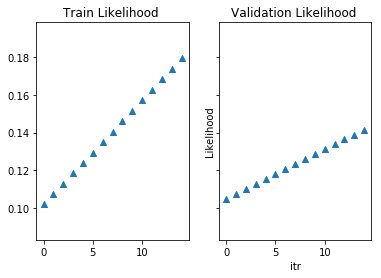

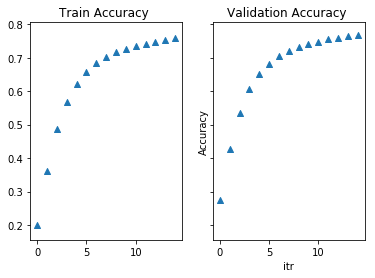

In [375]:
plot_loss_accuracy(itr,train_likelihood,val_likelihood,train_accuracy,val_accuracy)

### Inference: Batch =1024 ; Learning Rate =0.001 ;  

_1. Both the training accuracy and validation accuracy are low  76% Loss is 1.7 after 15 iteration Model is underfit_

_2. Due to very less learning rate the weights are updating slowly and slow convergence_

_3. we have to raise learning rate for faster convergence_


## 2. Batch =1024 ; Learning Rate =0.01 ; 

In [388]:
batch_size=1024
lr=0.01
itr=15
t_loss,v_loss,train_likelihood,val_likelihood,train_accuracy,val_accuracy=mnist_logistic_reg(batch_size,lr,itr,display_error=0)


 X_train :(60000, 784)

 Y_train :(60000, 10)

 batch size :1024

 Current iteration: 0 train_Accuracy: 0.5588080898633039 validation_Acc: 0.7502 train loss: 1.884781135016589 val loss: 1.8660275493779357

 Current iteration: 1 train_Accuracy: 0.7650507947872546 validation_Acc: 0.7855 train loss: 1.5878087921210837 val loss: 1.5686208691558858

 Current iteration: 2 train_Accuracy: 0.7874384054919138 validation_Acc: 0.8031 train loss: 1.3788456548196086 val loss: 1.3544831278671645

 Current iteration: 3 train_Accuracy: 0.8019902020360031 validation_Acc: 0.8154 train loss: 1.2286831822674087 val loss: 1.192872157976872

 Current iteration: 4 train_Accuracy: 0.8122074448883326 validation_Acc: 0.8223 train loss: 1.1173071251020605 val loss: 1.096144281090595

 Current iteration: 5 train_Accuracy: 0.819641277796496 validation_Acc: 0.8274 train loss: 1.0319959457815684 val loss: 1.00814336677287

 Current iteration: 6 train_Accuracy: 0.8254491360223335 validation_Acc: 0.8346 train loss: 0

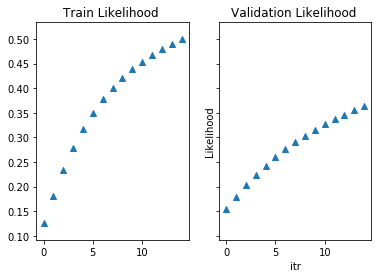

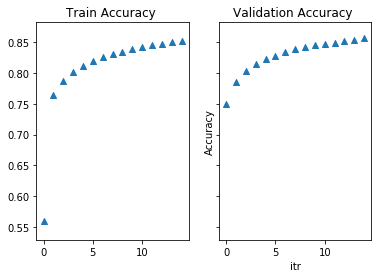

In [389]:
plot_loss_accuracy(itr,train_likelihood,val_likelihood,train_accuracy,val_accuracy)

### Inference: Batch =1024 ; Learning Rate =0.01 ; 

_1. Learning rate increased 10 times to 0.01 still training loss is high 0.6_

_2. To reduce loss with faster convergence lets increase lr further to 0.1_

## 3. Batch =1024 ; Learning Rate =0.1 ; 

In [395]:
batch_size=1024
lr=0.1
itr=15
t_loss,v_loss,train_likelihood,val_likelihood,train_accuracy,val_accuracy=mnist_logistic_reg(batch_size,lr,itr,display_error=0)


 X_train :(60000, 784)

 Y_train :(60000, 10)

 batch size :1024

 Current iteration: 0 train_Accuracy: 0.7867303318733154 validation_Acc: 0.8388 train loss: 0.818029190924758 val loss: 0.7976421680371206

 Current iteration: 1 train_Accuracy: 0.8527368568299962 validation_Acc: 0.8595 train loss: 0.6250358013887738 val loss: 0.6030712709636505

 Current iteration: 2 train_Accuracy: 0.8664252773633038 validation_Acc: 0.8698 train loss: 0.5470298145724886 val loss: 0.5362162488016953

 Current iteration: 3 train_Accuracy: 0.8744776875962649 validation_Acc: 0.8751 train loss: 0.5028382932246772 val loss: 0.4995470719461269

 Current iteration: 4 train_Accuracy: 0.8800629331921448 validation_Acc: 0.8814 train loss: 0.4736040449947197 val loss: 0.46254942668646015

 Current iteration: 5 train_Accuracy: 0.8835871317866769 validation_Acc: 0.8838 train loss: 0.45245115794468616 val loss: 0.43913181962798337

 Current iteration: 6 train_Accuracy: 0.8867003242924527 validation_Acc: 0.8861 train

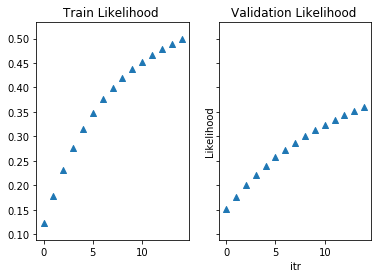

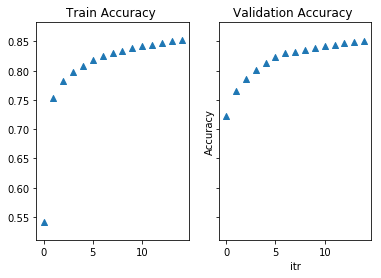

In [392]:
plot_loss_accuracy(itr,train_likelihood,val_likelihood,train_accuracy,val_accuracy)

### Inference: Batch =1024 ; Learning Rate =0.1 ; 

_1. Both validation and training Accuracy : 90% and less loss 0.37 therefore no underfit or over fit 

_2. Learning rate increased 10 times to 0.1 we have achieved faster convergence  _

_3. Lets reduce this learning rate by half to check stable and fast convergence_

## 4. Batch =1024 ; Learning Rate =0.05 ; 


In [394]:
batch_size=1024
lr=0.05
itr=15
t_loss,v_loss,train_likelihood,val_likelihood,train_accuracy,val_accuracy=mnist_logistic_reg(batch_size,lr,itr,display_error=0)


 X_train :(60000, 784)

 Y_train :(60000, 10)

 batch size :1024

 Current iteration: 0 train_Accuracy: 0.7554416002839816 validation_Acc: 0.8193 train loss: 1.0908481040530895 val loss: 1.0797580498039998

 Current iteration: 1 train_Accuracy: 0.8310543114651522 validation_Acc: 0.8435 train loss: 0.7997774999580491 val loss: 0.7990590283857324

 Current iteration: 2 train_Accuracy: 0.8478724700375433 validation_Acc: 0.858 train loss: 0.6763143750725027 val loss: 0.6775898689044617

 Current iteration: 3 train_Accuracy: 0.8570890841596073 validation_Acc: 0.8631 train loss: 0.6066028514644327 val loss: 0.6043632555185189

 Current iteration: 4 train_Accuracy: 0.8638776412687718 validation_Acc: 0.8672 train loss: 0.5610825585932728 val loss: 0.5554514933285503

 Current iteration: 5 train_Accuracy: 0.868713073377936 validation_Acc: 0.871 train loss: 0.5286425489179756 val loss: 0.5371580058308402

 Current iteration: 6 train_Accuracy: 0.872795307686754 validation_Acc: 0.8742 train loss:

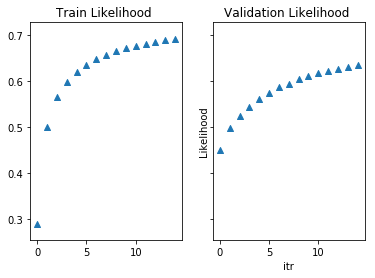

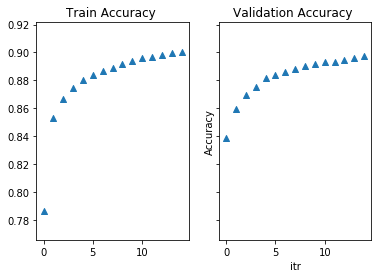

In [396]:
plot_loss_accuracy(itr,train_likelihood,val_likelihood,train_accuracy,val_accuracy)

### Inference: Batch =1024 ; Learning Rate =0.05 ; 

_1. Both validation and training Accuracy : 89% and less loss 0.42 therefore no underfit or over fit 

_2. Learning rate decreased half to 0.05 we have achieved faster convergence but loss is not better than 0.1  _

_3. For batch size of 1024 lr=0.1 is best available option_

_4. Lets reduce the Batch size for more frequent weight update 

## 5. Batch =128 ; Learning Rate =0.1 ; 

In [402]:
batch_size=128
lr=0.1
itr=15
t_loss,v_loss,train_likelihood,val_likelihood,train_accuracy,val_accuracy=mnist_logistic_reg(batch_size,lr,itr,display_error=0)


 X_train :(60000, 784)

 Y_train :(60000, 10)

 batch size :128

 Current iteration: 0 train_Accuracy: 0.8687979539641943 validation_Acc: 0.8922 train loss: 0.3286859325879911 val loss: 0.4103070713260523

 Current iteration: 1 train_Accuracy: 0.8991608056265984 validation_Acc: 0.9028 train loss: 0.2683290465860856 val loss: 0.38360240085918057

 Current iteration: 2 train_Accuracy: 0.9063339194373401 validation_Acc: 0.9075 train loss: 0.2423191413359671 val loss: 0.33140777874193816

 Current iteration: 3 train_Accuracy: 0.9105298913043478 validation_Acc: 0.91 train loss: 0.22674668007308227 val loss: 0.3328422299434732

 Current iteration: 4 train_Accuracy: 0.9134670716112532 validation_Acc: 0.9117 train loss: 0.21592556628332119 val loss: 0.3173285057815565

 Current iteration: 5 train_Accuracy: 0.9162843670076726 validation_Acc: 0.9132 train loss: 0.20774846890048398 val loss: 0.32621990319402505

 Current iteration: 6 train_Accuracy: 0.9177829283887468 validation_Acc: 0.9138 trai

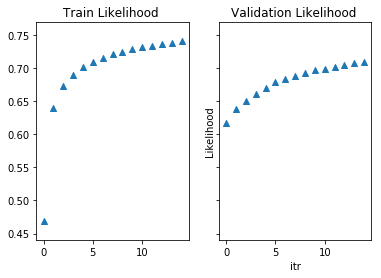

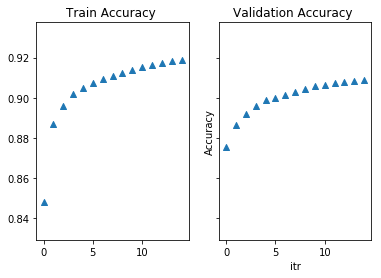

In [400]:
plot_loss_accuracy(itr,train_likelihood,val_likelihood,train_accuracy,val_accuracy)

### Inference: Batch =128 ; Learning Rate =0.1 ; 

_1. Both validation and training Accuracy : 91% and  loss 0.20  therefore no underfit or over fit 

_2. As batch size 128<1024 the convergence is faster and within 15 iteration we have achieved less loss

_3. Lets reduce batch size further to 32 

## 6.Batch =32 ; Learning Rate =0.1 ;

In [404]:
batch_size=32
lr=0.1
itr=15
t_loss,v_loss,train_likelihood,val_likelihood,train_accuracy,val_accuracy=mnist_logistic_reg(batch_size,lr,itr,display_error=0)


 X_train :(60000, 784)

 Y_train :(60000, 10)

 batch size :32

 Current iteration: 0 train_Accuracy: 0.9071697056941779 validation_Acc: 0.9047 train loss: 0.2831977224340673 val loss: 0.32041827866376277

 Current iteration: 1 train_Accuracy: 0.9243042226487524 validation_Acc: 0.9126 train loss: 0.24603855581548761 val loss: 0.3036325422318961

 Current iteration: 2 train_Accuracy: 0.9284428982725528 validation_Acc: 0.9147 train loss: 0.23286236431974672 val loss: 0.2807272987647911

 Current iteration: 3 train_Accuracy: 0.930662188099808 validation_Acc: 0.9159 train loss: 0.22667036900439572 val loss: 0.27935436271940944

 Current iteration: 4 train_Accuracy: 0.9322416826615483 validation_Acc: 0.9175 train loss: 0.2233008827941667 val loss: 0.2790173257790629

 Current iteration: 5 train_Accuracy: 0.9332613563659629 validation_Acc: 0.9182 train loss: 0.22113434984792835 val loss: 0.2599248402947379

 Current iteration: 6 train_Accuracy: 0.9340611004478567 validation_Acc: 0.919 train

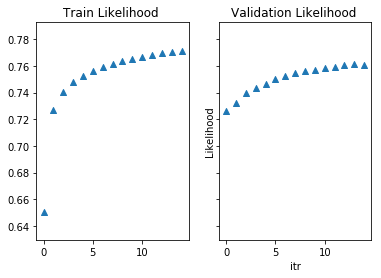

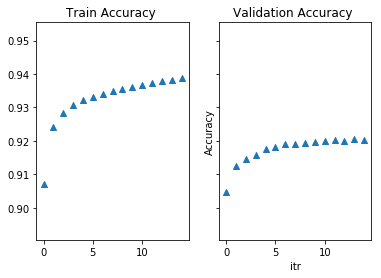

In [405]:
plot_loss_accuracy(itr,train_likelihood,val_likelihood,train_accuracy,val_accuracy)

### Inference: Batch =32 ; Learning Rate =0.1 ; 

_1. Both validation and training Accuracy : 92.5% and  loss 0.20  therefore no underfit or over fit 

_2. As batch size 32<128 the weight update convergence is faster and within 15 iteration we have achieved less loss

_3. Lets reduce batch size further to just 1 

In [408]:
batch_size=1
lr=0.1
itr=5
t_loss,v_loss,train_likelihood,val_likelihood,train_accuracy,val_accuracy=mnist_logistic_reg(batch_size,lr,itr,display_error=0)


 X_train :(60000, 784)

 Y_train :(60000, 10)

 batch size :1

 Current iteration: 0 train_Accuracy: 0.98574 validation_Acc: 0.8542 train loss: 1.1696944512989753 val loss: 0.9450147029086325

 Current iteration: 1 train_Accuracy: 0.98516 validation_Acc: 0.859 train loss: 0.08667416227033818 val loss: 0.9228015727214097

 Current iteration: 2 train_Accuracy: 0.985 validation_Acc: 0.8544 train loss: 0.003767314074399528 val loss: 0.9837033299525112

 Current iteration: 3 train_Accuracy: 0.98546 validation_Acc: 0.8683 train loss: 0.000437303093016473 val loss: 0.8346421714663069

 Current iteration: 4 train_Accuracy: 0.98576 validation_Acc: 0.8601 train loss: 0.10734620944025614 val loss: 0.9550224903454122

 The Final value of W:[[ 0.00667617 -0.00939718 -0.01052896 ... -0.00425239  0.00155979
   0.00021183]
 [-0.01741176  0.01089264 -0.00663844 ...  0.00390678 -0.01113942
  -0.00319204]
 [-0.00345043  0.00241935  0.00144848 ...  0.00174295 -0.01125871
   0.01066066]
 ...
 [ 0.00874218

### Inference: Batch =1 ; Learning Rate =0.1 ; 

_1. Weight update is very slow with limited data per batch; As the program is very slow stopped the program in 5 itr_

_2. Train loss is sub zero but val loss is more ; Val accuracy < Training accuracy__

_3. Model is __Overfit__ to the training images_

## Conclusion:

_1. Batch Size :32 with Learning rate : 0.1 seems to best fit choice for this Dataset_

_2. Learning rate is very less under fit with less iteration and takes longer time to converge_

_3. Larger Batch size takes longer time to update weight and slow convergence_

_4. Learning rate we can even adapt as for first few iterations larger learning rate and then reduce learning rate to tap the optimum solution_
        
    
        

